## Subdivision of the dataset into N institutions 

In [27]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

In [28]:
# Load data
df_train = pd.read_csv('diabetes_binary_5050split_health_indicators_BRFSS2015.csv')
print(df_train.shape)

(70692, 22)


### Random Subdivision 


In [29]:
# N institutions (5% out for testing)
N = 3

def random_split(df, N, file_prefix='df_split_random'):
    """
    Splits a DataFrame into N parts and saves each part as a CSV file.

    Parameters:
    df (pd.DataFrame): The DataFrame to split.
    N (int): Number of parts to split the DataFrame into.
    file_prefix (str): Prefix for the output file names.
    """
    # Shuffle the DataFrame
    df_shuffled = df.sample(frac=1, random_state=1).reset_index(drop=True)

    # Leave out 5% for testing
    df_train, df_test = train_test_split(df_shuffled, test_size=0.05, random_state=1)
    df_test.to_csv('df_test_random.csv', index=False)
    print(f'Saved: df_test_random.csv of shape {df_test.shape}')

    # Split the DataFrame into N parts
    df_splits = np.array_split(df_train, N)

    # Save each part as a CSV file
    for i, split in enumerate(df_splits, start=1):
        filename = f'{file_prefix}_{i}.csv'
        split.to_csv(filename, index=False)
        print(f'Saved: {filename} of shape {split.shape}')


random_split(df_train, N)


Saved: df_test_random.csv of shape (3535, 22)
Saved: df_split_random_1.csv of shape (22386, 22)


/Users/dariofenoglio/miniforge3/envs/CF_FL/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Saved: df_split_random_2.csv of shape (22386, 22)
Saved: df_split_random_3.csv of shape (22385, 22)


### Cluster based Subdivision

In [33]:
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import copy

# Function to calculate Euclidean distances between centroids
def centroid_distances(centroids0, centroids1):
    N = len(centroids0)
    print(f"N: {N}")
    distances = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            distances[i, j] = np.linalg.norm(centroids0[i] - centroids1[j])
    return distances

# Function to calculate centroids
def calculate_centroids(df, labels):
    N = len(np.unique(labels))
    centroids = []
    for i in range(N):
        centroids.append(df[labels == i].mean().to_numpy())
    return centroids

def cluster_by_class_split(df_train, N, file_prefix='df_split_2cluster'):
    """
    In this code, distances will be a matrix where the element at [i, j] represents
    the distance between the i-th cluster of class 0 and the j-th cluster of class 1.
    The final matrix will be a N x N matrix, not simmetrical in general.
    The following result means that for the first cluster of class 0, the second cluster 
    of class 1 is the closest one. For the second cluster of class 0, the third cluster of
    class 1 is the closest one. And so on.
    array([[22.52661847, 16.58598092, 30.50548191],
       [ 4.33080647, 32.17891945, 25.41195157],
       [27.11059815, 19.7759446 ,  8.12520036]])
    """

    # Leave out 5% for testing
    df_train, df_test = train_test_split(df_train, test_size=0.05, random_state=1)
    df_test.to_csv('df_test_2cluster.csv', index=False)
    print(f'Saved: df_test_2cluster.csv of shape {df_test.shape}')

    # Splitting the dataset by class
    df_train_0 = df_train[df_train['Diabetes_binary'] == 0].drop('Diabetes_binary', axis=1)
    df_train_1 = df_train[df_train['Diabetes_binary'] == 1].drop('Diabetes_binary', axis=1)
    # KMeans clustering
    kmeans_0 = KMeans(n_clusters=N, random_state=1).fit(df_train_0)
    kmeans_1 = KMeans(n_clusters=N, random_state=1).fit(df_train_1)
    # Calculating centroids
    centroids_0 = calculate_centroids(df_train_0, kmeans_0.labels_)
    centroids_1 = calculate_centroids(df_train_1, kmeans_1.labels_)
    # Calculating distances
    distance_matrix = centroid_distances(centroids_0, centroids_1)  

    # Pairing clusters
    pairs = pair_clusters(distance_matrix)

    # create the N clusters
    i = 1
    for c0,c1 in pairs:
        df_0 = df_train[df_train['Diabetes_binary'] == 0][kmeans_0.labels_ == c0]
        df_1 = df_train[df_train['Diabetes_binary'] == 1][kmeans_1.labels_ == c1]
        # merge the clusters
        df = pd.concat([df_0, df_1])
        # randomize the order of the rows
        df = df.sample(frac=1).reset_index(drop=True)
        # save the new dataset
        df.to_csv(f'{file_prefix}_{i}.csv', index=False)
        print(f'Saved: {file_prefix}_{i}.csv of shape {df.shape} pairs: {c0} and {c1}')
        i += 1

def pair_clusters(dist_matrix):
    distances_copy = copy.deepcopy(dist_matrix)
    pairs = []
    # cycle
    while distances_copy.size > 0:
        # Find the minimum value and its column index
        min_value = np.min(distances_copy)
        min_col_index = np.argmin(np.min(distances_copy, axis=0))
        min_row_index = np.argmin(distances_copy[:, min_col_index])

        # identify the real position 
        ind = np.where(dist_matrix == min_value) #print("Minimum value:", min_value)#print("Column index of minimum value:", ind[1])#print("Row index of minimum value:", ind[0])

        # record pairing 
        pairs.append((ind[1].item(0), ind[0].item(0)))  # (cluster_{min_col_index}_0, cluster_{min_row_index}_1)

        # remove the paired clusters from further consideration
        distances_copy = np.delete(distances_copy, min_row_index, axis=0)  # remove row
        distances_copy = np.delete(distances_copy, min_col_index, axis=1)  # remove column

    return pairs

cluster_by_class_split(df_train, N)


Saved: df_test_cluster.csv of shape (3535, 22)
N: 3
Saved: df_split_2cluster_1.csv of shape (9125, 22) pairs: 1 and 2
Saved: df_split_2cluster_2.csv of shape (51958, 22) pairs: 2 and 1
Saved: df_split_2cluster_3.csv of shape (6074, 22) pairs: 0 and 0


In [35]:
# N institutions - clusters _ OLD VERSION
N = 3

def cluster_split(df, N, file_prefix='df_split_cluster'):
    """
    Splits a DataFrame into N clusters and saves each cluster as a CSV file.

    Parameters:
    df (pd.DataFrame): The DataFrame to cluster.
    N (int): Number of clusters to form.
    file_prefix (str): Prefix for the output file names.
    """

    # Leave out 5% for testing
    df_train, df_test = train_test_split(df, test_size=0.05, random_state=1)
    df_test.to_csv('df_test_cluster.csv', index=False)
    print(f'Saved: df_test_cluster.csv of shape {df_test.shape}')

    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=N, random_state=1)
    clusters = kmeans.fit_predict(df_train)

    # Split the DataFrame based on clusters
    for i in range(N):
        cluster_df = df_train[clusters == i]
        filename = f'{file_prefix}_{i+1}.csv'
        cluster_df.to_csv(filename, index=False)
        print(f'Saved: {filename} of shape {cluster_df.shape}')


cluster_split(df_train, N)


Saved: df_test_cluster.csv of shape (3535, 22)
Saved: df_split_cluster_1.csv of shape (10251, 22)
Saved: df_split_cluster_2.csv of shape (52189, 22)
Saved: df_split_cluster_3.csv of shape (4717, 22)


#### Double-Check 

In [18]:
# read the data
df1 = pd.read_csv('df_split_cluster1.csv')
df2 = pd.read_csv('df_split_cluster2.csv')
df3 = pd.read_csv('df_split_cluster3.csv')

df4 = pd.read_csv('df_split_random1.csv')
df5 = pd.read_csv('df_split_random2.csv')
df6 = pd.read_csv('df_split_random3.csv')

# print the shape of the data
print(f"Total shape cluster: {df1.shape[0] + df2.shape[0] + df3.shape[0]},{df1.shape[1]}")
print(f"Total shape random: {df4.shape[0] + df5.shape[0] + df6.shape[0]}, {df4.shape[1]}")

Total shape cluster: 70692,22
Total shape random: 70692, 22


In [19]:
df1.head()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,0.0,1.0,58.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,3.0,3.0,3.0,0.0,1.0,10.0,4.0,6.0
1,0.0,0.0,0.0,1.0,38.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,2.0,2.0,0.0,0.0,6.0,5.0,7.0
2,0.0,0.0,1.0,1.0,40.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,7.0,5.0,8.0
3,0.0,0.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,20.0,0.0,0.0,0.0,9.0,4.0,6.0
4,0.0,0.0,0.0,1.0,36.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,1.0,7.0,6.0,6.0


In [20]:
df4.head()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,0.0,1.0,30.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,5.0,2.0
1,1.0,1.0,1.0,1.0,33.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,3.0,0.0,0.0,0.0,1.0,4.0,5.0,7.0
2,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,2.0,0.0,0.0,0.0,1.0,9.0,5.0,6.0
3,0.0,0.0,0.0,1.0,25.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,13.0,6.0,8.0
4,1.0,0.0,1.0,1.0,29.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,3.0,0.0,0.0,0.0,1.0,11.0,6.0,3.0


In [22]:
import csv
import os

d = pd.read_csv('../histories/metrics_client_1.csv')
d.head()
#




,Round,Loss,Accuracy
0,1,0.682939,0.530025
1,2,0.654300,0.695534
2,3,0.626866,0.707196
3,4,0.599270,0.706452
4,5,0.577951,0.708685



Minimum Loss occurred at round 18 with a loss value of 0.5650849938392639
Maximum Accuracy occurred at round 50 with an accuracy value of 0.721588134765625



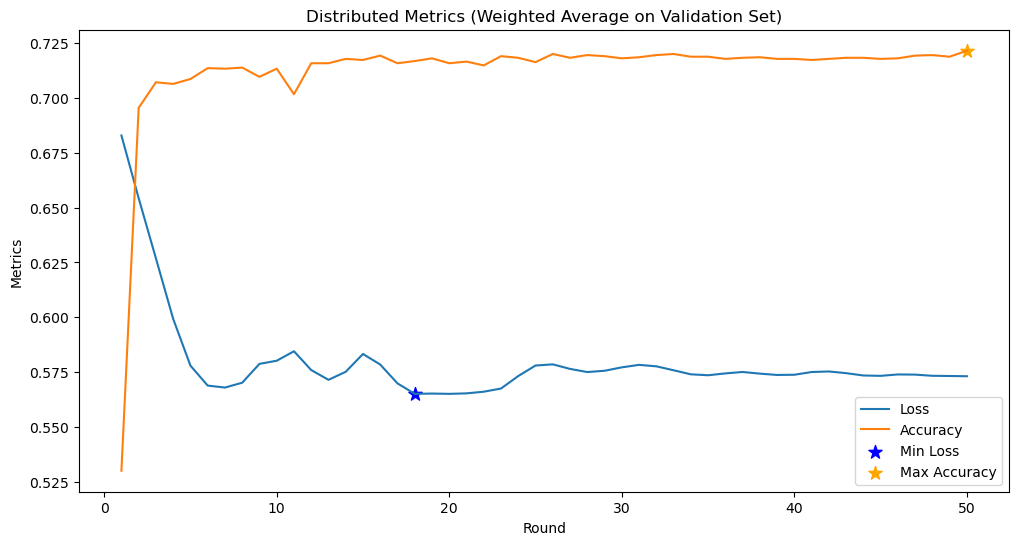

In [26]:
import os
import matplotlib.pyplot as plt
import pandas as pd



# Example usage
# Assuming you have a DataFrame 'df_metrics' with columns 'round', 'loss', 'accuracy'
# plot_loss
plot_loss_and_accuracy(d, 1)